In [94]:
import pandas as pd
import numpy as p
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import spacy

from sklearn.model_selection import train_test_split
from time import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier


In [2]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# Reading data

In [3]:
# download the data from kaggle
train_df=pd.read_csv("train.csv")

In [4]:
train_df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


# Checking missing values

In [5]:
print("Check for missing values in dataset: ", train_df.isnull().sum().sum())

Check for missing values in dataset:  0


# Exploratory data analysis

Let's check how many articles are included in each category.

In [5]:
categories=["Computer Science","Physics","Mathematics","Statistics","Quantitative Biology","Quantitative Finance"]
category_count=[]
for i in categories:
  category_count.append(train_df[i].sum()) 

Text(0.5, 1.0, 'Number of articles in each category')

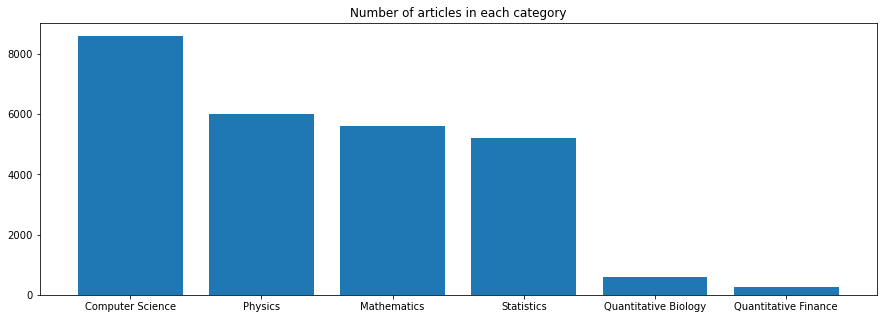

In [7]:
plt.figure(figsize=(15,5))
plt.bar(categories,category_count)
plt.title("Number of articles in each category")

Conclusion: The dataset is imbalanced. We can see that there are significantly more articles belonging to the Computer Science category than to the Quantitative Biology or Quantitative Finance categories.

In [8]:
total_word_count_in_each_category=[]
for i in categories:
  abstracts = train_df.where(train_df[i]==1)[['ABSTRACT']] 
  count=pd.Series(abstracts.values.flatten()).str.len().sum()
  total_word_count_in_each_category.append(count)

In [9]:
avg_abstract_len_for_each_category=[]
for i in range(6):
  avg_abstract_len_for_each_category.append(total_word_count_in_each_category[i]/category_count[i])

Now we can see the average number of words contained in an article of each category.

Text(0.5, 1.0, 'Average word length of abstract for each category')

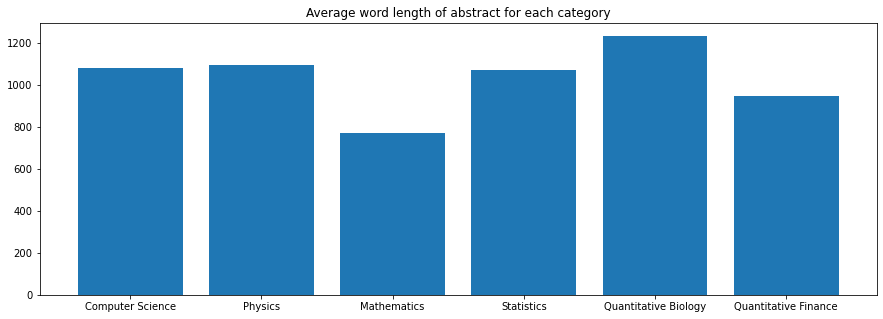

In [10]:
plt.figure(figsize=(15,5))
plt.bar(categories,avg_abstract_len_for_each_category)
plt.title("Average word length of abstract for each category")

From the above plot its clear that articles of quantitaive biology are longest, and mathematics articles are shortest.

In [11]:
count_numeric_contained_texts=dict()
for category in categories:
    count_numeric_contained_texts[category]=0

In [12]:
for category in categories:
    for text in train_df[train_df[category]==1]["ABSTRACT"]:
        if re.findall("\d",text):
            count_numeric_contained_texts[category]+=1 

In [13]:
for i in range(len(categories)):
    count_numeric_contained_texts[categories[i]]=count_numeric_contained_texts[categories[i]]/category_count[i]

Now we can see the average number of numeric values contained in an article of each category.

<BarContainer object of 6 artists>

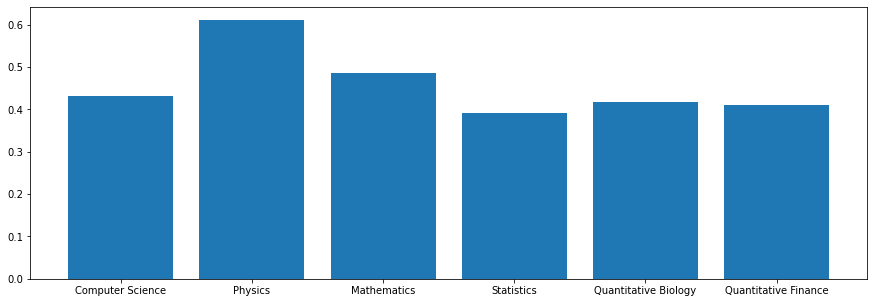

In [14]:
plt.figure(figsize=(15,5))
plt.bar(categories,count_numeric_contained_texts.values())

Each category have numeric values in almost 40% texts except physics, also physics doesnt have significant difference, so numeric values in abstracts doesnt add any significant difference between categories, so we will just remove the numeric values from text preprocessing step.

# Data preprocessing

Concatenation of Title and Abstract to make it one text

In [6]:
train_df["text"]=train_df["TITLE"] +" "+ train_df["ABSTRACT"]

Dropping the TITLE and ABSTRACT columns.

In [7]:
train_df.drop(["TITLE","ABSTRACT"], axis=1,inplace=True)

In [12]:
train_df.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text
0,1,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps ...
1,2,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation ...
2,3,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...
3,4,0,0,1,0,0,0,A finite element approximation for the stochas...
4,5,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...


In [8]:
def split(X, y,test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=42)
    return (X_train, X_test, y_train, y_test)

# Lemmatizing

Performing lemmatization of words and regular expressions using the spacy library.

In [19]:
import spacy
print(spacy.__file__) 

C:\Users\LEGION\anaconda3\lib\site-packages\spacy\__init__.py


In [20]:
nlp=spacy.load('en_core_web_sm',disable=['ner','parser'])

Replace non-letter characters with a space and convert all uppercase letters to lowercase.

In [21]:
brief_cleaning=(re.sub("[^a-zA-Z]+"," ",str(text)).lower() for text in train_df["text"])

In [22]:
def cleaning(doc):
    txt=[token.lemma_ for token in doc if not token.is_stop]
    txt=[txt for txt in txt if len(txt)>1]
    return " ".join(txt)

In [23]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=2000)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 4.16 mins


In [24]:
cleaned_title2=[]
for i in range(train_df.shape[0]):
    title1=train_df.text[i] 
    title1=title1.lower().strip() 
    title1=re.sub("\n"," ",title1) 
    title1=re.sub("[^a-zA-Z0-9 +]"," ",title1)
    title1=nlp(title1) 
    title1=[token.lemma_.strip() for token in title1 if (not token.is_stop) and (len(token)>1)]
    title1=" ".join(title1)
    title1=re.sub(" +"," ",title1)
    cleaned_title2.append(title1)

Save this cleaned text to a csv file so that we don't have run above cell every time because it is time taking.

In [4]:
df1 = pd.DataFrame(cleaned_title2)
df1.to_csv("cleaned_text_2.csv")

In [9]:
cleaned_text=pd.read_csv("cleaned_text_2.csv")
cleaned_text=list(cleaned_text['0'].values)
cleaned_text[:3]

['reconstruct subject specific effect map predictive model allow subject specific inference analyze disease relate alteration neuroimage datum give subject data inference level global identifiye condition presence subject local detect condition effect individual measurement extract subject data global inference widely local inference form subject specific effect map rarely exist model yield noisy detection compose disperse isolate island article propose reconstruction method name rsm improve subject specific detection predictive modeling approach particular binary classifier rsm specifically aim reduce noise sample error associate finite sample example train classifier propose method wrapper type algorithm different binary classifier diagnostic manner information condition presence reconstruction pose maximum posteriori problem prior model parameter estimate train datum classifier specific fashion experimental evaluation perform synthetically generate datum datum alzheimer disease neur

In [7]:
len(cleaned_text)

20972

In [10]:
train_df['cleaned_text']=cleaned_text
train_df.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text,cleaned_text
0,1,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps ...,reconstruct subject specific effect map predic...
1,2,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation ...,rotation invariance neural network rotation in...
2,3,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...,spherical polyharmonic poisson kernel polyharm...
3,4,0,0,1,0,0,0,A finite element approximation for the stochas...,finite element approximation stochastic maxwel...
4,5,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...,comparative study discrete wavelet transform w...


In [11]:
X = train_df.loc[:,"cleaned_text"]
y = train_df.loc[:,categories]

In [12]:
X.shape,y.shape

((20972,), (20972, 6))

Checking the lengths of texts and presenting them on a histogram.

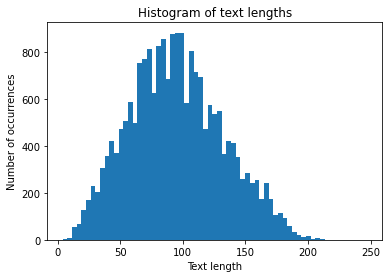

In [13]:
lengths = [len(text.split()) for text in list(X)]

plt.hist(lengths, bins='auto')
plt.xlabel('Text length')
plt.ylabel('Number of occurrences')
plt.title('Histogram of text lengths')
plt.show()

In [14]:
X_train,X_test,y_train,y_test=split(X,y,0.2)

In [15]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((16777,), (4195,), (16777, 6), (4195, 6))

# Tokenization and Padding

Due to the fact that the majority of articles consist of around 100 words, we set the length of our tokens to 100.

In [16]:
max_length = 100

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)

In [18]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

In [19]:
print(X_test_seq[1])

[2602, 770, 2129, 960, 2602, 770, 212, 239, 1780, 770, 66, 344, 2, 331, 333, 581, 119, 28, 838, 22, 1627, 2602, 770, 428, 2129, 1045, 2, 7, 121, 28, 12, 647, 3312, 8, 10, 2602, 770, 268, 3, 27, 166, 1646, 2602, 770, 476, 6844, 3008, 24902, 56, 590, 40]


In [20]:
print(X_train_pad[1])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0  1408    42   245    14    82  4693     6  2498   756
    46  4005  4470  2894   756  4243  6378   190  4693     6   756   833
    46  4005  4470  2894   756   756  1764    40  1764  1385 26420  3206
  4470  1033 16698 12657  6378  2933  1795 16698 16698  3206  4470  1033
 26421 12657  6378  2933  1795   182  1385   182    40 12657  6378 26422
  6378  1650  4693     6   711    41  1196    46  4005  4470  2894  1196
    24  2498  2124  1196   833    46  4005  4470  4005  6379  2894   756
  4177  1988   250   309]


# Creating an LSTM model with an Embedding layer

In [21]:
vocab_size = len(tokenizer.word_index) +1
embedding_dim = 50
vocab_size

42134

In [24]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(units=256, return_sequences=True)))  
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=128)))
model.add(Dropout(0.5))
model.add(Dense(units=6, activation='sigmoid'))

In [25]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
model.fit(X_train_pad, y_train, batch_size=32, epochs=10, validation_data=(X_test_pad, y_test))

Epoch 1/10
525/525 [==============================] - 663s 1s/step - loss: 0.3892 - accuracy: 0.5260 - val_loss: 0.3198 - val_accuracy: 0.6515
Epoch 2/10
525/525 [==============================] - 669s 1s/step - loss: 0.2973 - accuracy: 0.7189 - val_loss: 0.2582 - val_accuracy: 0.7614
Epoch 3/10
525/525 [==============================] - 562s 1s/step - loss: 0.2322 - accuracy: 0.7917 - val_loss: 0.2575 - val_accuracy: 0.7640
Epoch 4/10
525/525 [==============================] - 554s 1s/step - loss: 0.1971 - accuracy: 0.8012 - val_loss: 0.2591 - val_accuracy: 0.7385
Epoch 5/10
525/525 [==============================] - 690s 1s/step - loss: 0.1663 - accuracy: 0.8042 - val_loss: 0.2399 - val_accuracy: 0.7249
Epoch 6/10
525/525 [==============================] - 691s 1s/step - loss: 0.1430 - accuracy: 0.8071 - val_loss: 0.2362 - val_accuracy: 0.7387
Epoch 7/10
525/525 [==============================] - 706s 1s/step - loss: 0.1179 - accuracy: 0.8217 - val_loss: 0.2582 - val_accuracy: 0.7476

In [27]:
y_train_pred = model.predict(X_train_pad)

525/525 [==============================] - 172s 324ms/step


In [28]:
y_test_pred = model.predict(X_test_pad)

132/132 [==============================] - 42s 321ms/step


In [29]:
y_train_pred

array([[8.5255401e-03, 5.9623141e-02, 1.9396225e-02, 9.7109482e-02,
        7.8264230e-01, 4.2296898e-01],
       [1.3079192e-03, 9.2929107e-04, 9.9943107e-01, 1.3610752e-03,
        3.4048724e-06, 5.2433512e-05],
       [9.9901730e-01, 3.7108262e-03, 3.8049116e-03, 1.2631640e-02,
        2.4338296e-04, 2.4616214e-05],
       ...,
       [1.0720866e-03, 9.9986464e-01, 6.1691279e-04, 3.8052685e-04,
        6.1036728e-05, 1.7351505e-05],
       [9.9973685e-01, 5.1875523e-04, 1.9005962e-03, 5.6600668e-03,
        3.6435220e-05, 3.2833120e-06],
       [9.9916679e-01, 6.3497247e-04, 7.9208137e-03, 2.0533251e-02,
        8.4774816e-05, 2.4245543e-05]], dtype=float32)

In [30]:
import numpy as np
threshold = 0.7

y_train_pred_binary = np.where(y_train_pred >= threshold, 1, 0)
y_test_pred_binary = np.where(y_test_pred >= threshold, 1, 0)

In [31]:
for row in y_train_pred_binary:
    if np.sum(row) >= 3:
        print(row)

[1 0 1 1 0 0]
[1 0 1 1 0 0]
[1 0 1 1 0 0]
[1 0 1 1 0 0]
[1 0 1 1 0 0]
[1 0 1 1 0 0]
[1 0 1 1 0 0]
[1 0 1 1 0 0]
[1 0 1 1 0 0]
[1 0 1 1 0 0]
[1 0 1 1 0 0]
[1 0 1 1 0 0]
[1 0 1 1 0 0]
[1 0 1 1 0 0]
[1 0 1 1 0 0]
[1 0 1 1 0 0]
[1 0 1 1 0 0]
[1 0 1 1 0 0]
[1 0 1 1 0 0]
[1 0 1 1 0 0]
[1 0 1 1 0 0]
[1 0 1 1 0 0]
[1 0 1 1 0 0]
[1 0 1 1 0 0]
[1 0 1 1 0 0]


In [32]:
cr = classification_report(
    y_test,
    y_test_pred_binary ,
    target_names=categories
)
print(cr)

                      precision    recall  f1-score   support

    Computer Science       0.77      0.79      0.78      1692
             Physics       0.89      0.81      0.85      1226
         Mathematics       0.81      0.73      0.77      1150
          Statistics       0.73      0.67      0.70      1069
Quantitative Biology       0.31      0.09      0.14       122
Quantitative Finance       0.50      0.02      0.04        45

           micro avg       0.79      0.73      0.76      5304
           macro avg       0.67      0.52      0.55      5304
        weighted avg       0.78      0.73      0.75      5304
         samples avg       0.78      0.77      0.76      5304



C:\Users\LEGION\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score

def plot_confusion_matrix(y_true, y_pred, labels):
    c_matrix = multilabel_confusion_matrix(y_true, y_pred)
    accuracy_per_class = {}

    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    plt.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axs.flatten()):
        if i >= len(labels):
            ax.axis('off')
            continue

        label = labels[i]
        tn, fp, fn, tp = c_matrix[i].ravel()

        # Calculate accuracy for current class
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        accuracy_per_class[label] = accuracy

        # Plot confusion matrix
        sns.heatmap(c_matrix[i] / np.sum(c_matrix[i]), fmt=".2%", annot=True, cmap='Blues', ax=ax)
        ax.set_title(label, fontsize=14)
        ax.set_xlabel('Predicted', fontsize=12)
        ax.set_ylabel('Actual', fontsize=12)

    plt.tight_layout()
    plt.show()

    # Print accuracy per class
    print("Accuracy per class:")
    for label, accuracy in accuracy_per_class.items():
        print(label, ":", accuracy)
        
    print("All accuracy: ", accuracy_score(y_test, y_pred))


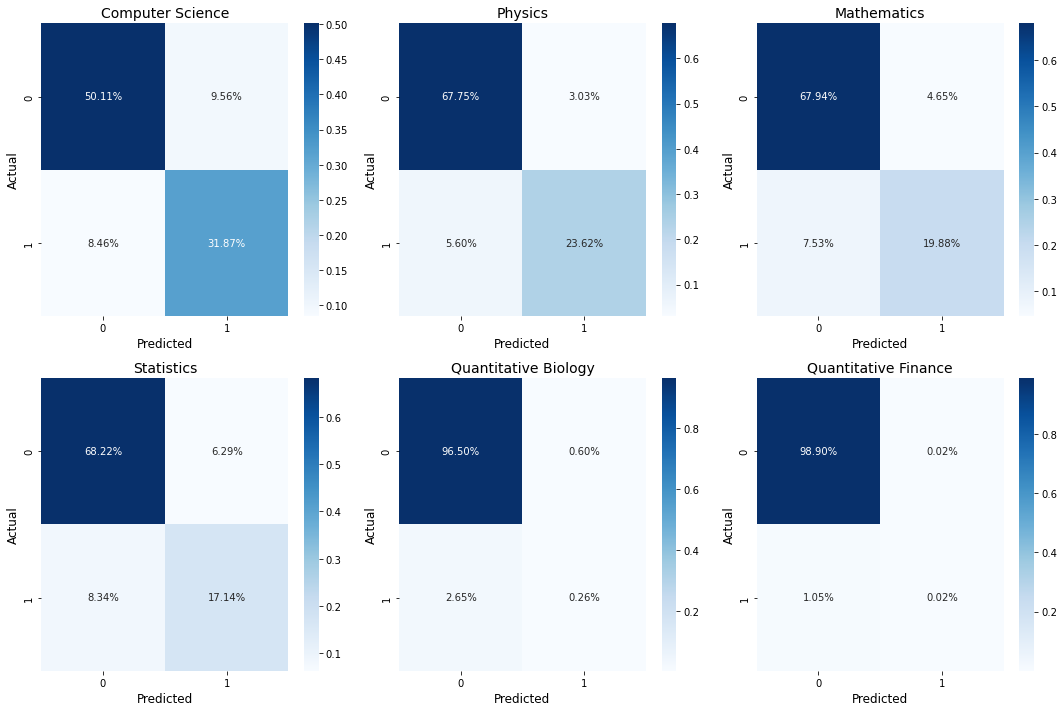

Accuracy per class:
Computer Science : 0.8197854588796186
Physics : 0.9137067938021454
Mathematics : 0.8781883194278903
Statistics : 0.8536352800953516
Quantitative Biology : 0.967580452920143
Quantitative Finance : 0.9892729439809297
All accuracy:  0.5873659117997616


In [34]:
plot_confusion_matrix(y_test, y_test_pred_binary , categories)

# Visualization of results


In [36]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_all(y,y_pred):
    c_matrix=confusion_matrix(y,y_pred)

    c_matrix=pd.DataFrame(c_matrix,columns=['Computer Science',
     'Physics',
     'Mathematics',
     'Statistics',
     'Quantitative Biology',
     'Quantitative Finance'],index=['Computer Science',
     'Physics',
     'Mathematics',
     'Statistics',
     'Quantitative Biology',
     'Quantitative Finance'])

    fig,ax=plt.subplots(figsize=(12,12))
    sns.set(font_scale=1.4)
    sns.heatmap(c_matrix/np.sum(c_matrix),fmt="0.2%",annot=True,cmap="Blues",ax=ax)
    ax.set_title("Confusion matrix ",fontsize=26)
    ax.set_xlabel("Predicted",fontsize=26)
    ax.set_ylabel("Actual",fontsize=26)

In [37]:
result = []

for i in range(6):
    sub_matrix = np.column_stack((y_test_pred[:, i], 1 - y_test_pred[:, i]))
    result.append(sub_matrix)

print(result)

[array([[9.99140263e-01, 8.59737396e-04],
       [8.83880675e-01, 1.16119325e-01],
       [9.98651266e-01, 1.34873390e-03],
       ...,
       [1.61261682e-03, 9.98387396e-01],
       [2.37974199e-03, 9.97620285e-01],
       [9.47776973e-01, 5.22230268e-02]], dtype=float32), array([[2.6353097e-03, 9.9736470e-01],
       [1.2271230e-02, 9.8772877e-01],
       [4.2302818e-03, 9.9576974e-01],
       ...,
       [7.6436174e-01, 2.3563826e-01],
       [9.9985927e-01, 1.4072657e-04],
       [3.4239948e-02, 9.6576005e-01]], dtype=float32), array([[1.5056612e-03, 9.9849433e-01],
       [6.6809803e-01, 3.3190197e-01],
       [6.4726276e-03, 9.9352735e-01],
       ...,
       [9.7955883e-01, 2.0441175e-02],
       [7.9100940e-04, 9.9920899e-01],
       [1.1800957e-01, 8.8199043e-01]], dtype=float32), array([[2.7752431e-02, 9.7224754e-01],
       [8.0447957e-02, 9.1955203e-01],
       [2.4813583e-02, 9.7518641e-01],
       ...,
       [2.1257207e-03, 9.9787426e-01],
       [4.2808495e-04, 9.99571

In [38]:
y_test_1 = y_test

In [39]:
y_test = y_test.values

In [40]:
from collections import defaultdict
import numpy as np
import pandas as pd
def matrix_prob(y_test, result):
#     y_test = y_test.values

    # Assuming predicted_probabilities and y_test are available
    class_names = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']
    num_classes = len(class_names)

    class_assignments = defaultdict(lambda: defaultdict(float))
    class_counts = np.zeros(num_classes)  # Count of occurrences for each class

    # Get the predicted probabilities from the best_model
    predicted_probabilities = result


    for i, array in enumerate(predicted_probabilities):

        for j, row in enumerate(array):
            true_class = y_test[j]
            for k, label in enumerate(true_class):
                if label == 1:
                    class_assignments[k][i] += row[1]
                    class_counts[k] += 1

    # Calculate average probabilities for each class-to-class assignment
    class_average_probabilities = np.zeros((num_classes, num_classes))

    for i in range(num_classes):
        for j in range(num_classes):
            if class_counts[i] != 0:
                class_average_probabilities[i][j] = class_assignments[i][j] / class_counts[i]

    # Normalize the probabilities for each class
    class_sums = np.sum(class_average_probabilities, axis=1, keepdims=True)
    class_average_probabilities /= class_sums

    # Convert the results to a DataFrame
    df = pd.DataFrame(class_average_probabilities, columns=class_names, index=class_names)

    # Print the DataFrame or use it for further analysis
    df

In [41]:
df = matrix_prob(y_test, result)
df

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
Computer Science,0.041315,0.202143,0.187630,0.139670,0.212999,0.216243
Physics,0.173740,0.034708,0.189801,0.199589,0.199161,0.203001
Mathematics,0.164310,0.192950,0.051121,0.169469,0.211522,0.210628
Statistics,0.090826,0.219160,0.178916,0.067833,0.219772,0.223494
Quantitative Biology,0.113357,0.158423,0.206951,0.147108,0.169890,0.204272
Quantitative Finance,0.161300,0.187075,0.173240,0.125913,0.174045,0.178427


In [42]:
# Create a heatmap
def heatmap_prob(df):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, cmap='YlGnBu', fmt='.2f', cbar=True)
    plt.title('Class-to-Class Assignment Probabilities')
    plt.xlabel('Assigned Class')
    plt.ylabel('True Class')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

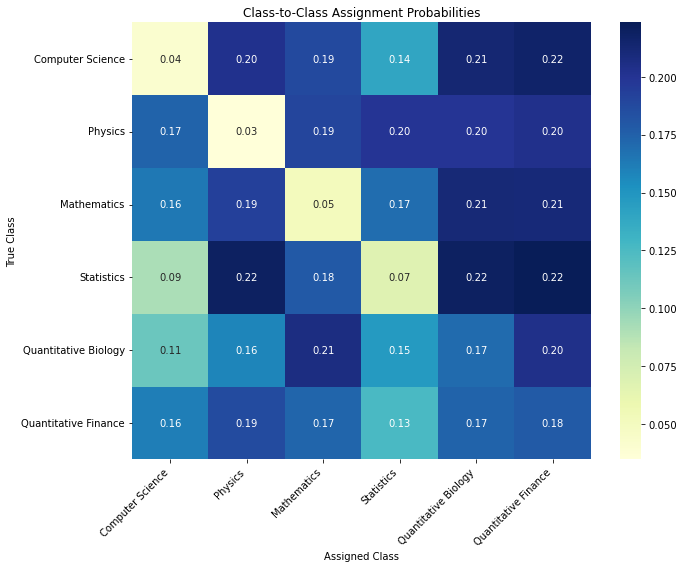

In [43]:
heatmap_prob(df)

# Undersampling

In [44]:
# Inicjalizacja słownika, który przechowuje liczność wierszy dla każdej kategorii
category_counts = {}

# Przejście przez każdą kategorię
for category in train_df.columns[1:-1]:
    # Wybieranie wierszy dla danej kategorii
    category_data = train_df[train_df[category] == 1]

    # Sprawdzanie, czy liczba wierszy w kategorii jest większa lub równa 249
    if len(category_data) >= 249:
        # Wybieranie losowych 249 wierszy
        category_data = category_data.sample(n=249, random_state=42)
    else:
        # Wybieranie wszystkich dostępnych wierszy
        category_data = category_data

    # Dodawanie wybranych wierszy do słownika
    category_counts[category] = category_data

# Tworzenie równoważnego zbioru danych
balanced_data = pd.concat(category_counts.values(), ignore_index=True)

In [45]:
categories=["Computer Science","Physics","Mathematics","Statistics","Quantitative Biology","Quantitative Finance"]
category_count=[]
for i in categories:
  category_count.append(train_df[i].sum())
category_count

[8594, 6013, 5618, 5206, 587, 249]

In [46]:
categories=["Computer Science","Physics","Mathematics","Statistics","Quantitative Biology","Quantitative Finance"]
category_count_balanced=[]
for i in categories:
  category_count_balanced.append(balanced_data[i].sum())

Text(0.5, 1.0, 'Number of articles in each category')

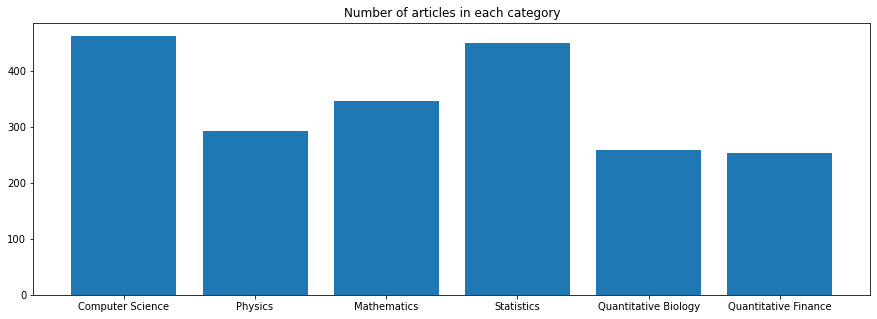

In [47]:
plt.figure(figsize=(15,5))
plt.bar(categories,category_count_balanced)
plt.title("Number of articles in each category")

In [48]:
X_train,X_test,y_train,y_test=split(balanced_data.loc[:,"cleaned_text"],balanced_data.loc[:,categories],0.2)

In [49]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [50]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)

In [51]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

# LSTM model 

In [52]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(units=256, return_sequences=True)))  
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=128)))
model.add(Dropout(0.5))
model.add(Dense(units=6, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
undersampling_history = model.fit(X_train_pad, y_train, batch_size=32, epochs=10, validation_data=(X_test_pad, y_test))

Epoch 1/10
38/38 [==============================] - 53s 1s/step - loss: 0.5657 - accuracy: 0.2042 - val_loss: 0.5313 - val_accuracy: 0.2943
Epoch 2/10
38/38 [==============================] - 37s 969ms/step - loss: 0.5230 - accuracy: 0.2904 - val_loss: 0.4883 - val_accuracy: 0.3144
Epoch 3/10
38/38 [==============================] - 45s 1s/step - loss: 0.4541 - accuracy: 0.4318 - val_loss: 0.4443 - val_accuracy: 0.4783
Epoch 4/10
38/38 [==============================] - 49s 1s/step - loss: 0.3467 - accuracy: 0.6335 - val_loss: 0.3868 - val_accuracy: 0.5953
Epoch 5/10
38/38 [==============================] - 50s 1s/step - loss: 0.2630 - accuracy: 0.7515 - val_loss: 0.3729 - val_accuracy: 0.5585
Epoch 6/10
38/38 [==============================] - 48s 1s/step - loss: 0.2061 - accuracy: 0.7992 - val_loss: 0.3889 - val_accuracy: 0.5719
Epoch 7/10
38/38 [==============================] - 50s 1s/step - loss: 0.1497 - accuracy: 0.8318 - val_loss: 0.4302 - val_accuracy: 0.5318
Epoch 8/10
38/38 

In [54]:
y_train_pred_u = model.predict(X_train_pad)

38/38 [==============================] - 15s 303ms/step


In [55]:
y_test_pred_u = model.predict(X_test_pad)

10/10 [==============================] - 3s 252ms/step


In [56]:
import numpy as np
threshold = 0.7

y_train_pred_binary_u = np.where(y_train_pred_u >= threshold, 1, 0)
y_test_pred_binary_u = np.where(y_test_pred_u >= threshold, 1, 0)

In [57]:
cr = classification_report(
    y_test,
    y_test_pred_binary_u ,
    target_names=categories
)
print(cr)

                      precision    recall  f1-score   support

    Computer Science       0.58      0.45      0.51        88
             Physics       0.90      0.42      0.57        64
         Mathematics       0.76      0.66      0.71        62
          Statistics       0.71      0.56      0.62        88
Quantitative Biology       0.59      0.59      0.59        58
Quantitative Finance       0.67      0.73      0.70        49

           micro avg       0.68      0.56      0.61       409
           macro avg       0.70      0.57      0.62       409
        weighted avg       0.70      0.56      0.61       409
         samples avg       0.63      0.58      0.59       409



C:\Users\LEGION\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


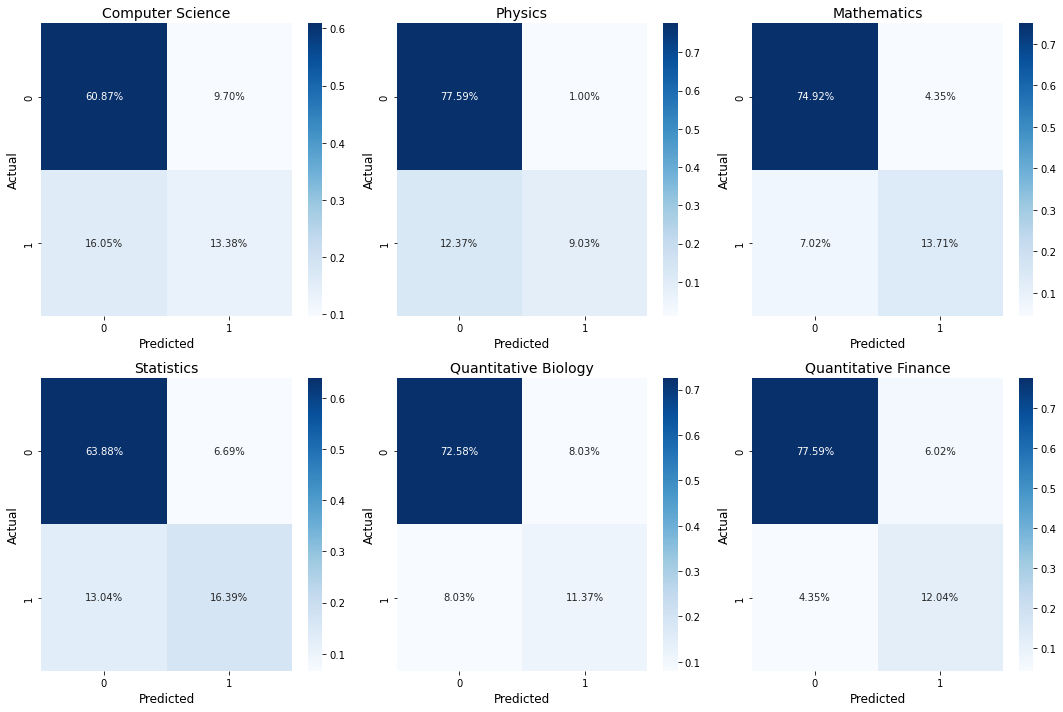

Accuracy per class:
Computer Science : 0.7424749163879598
Physics : 0.8662207357859532
Mathematics : 0.8862876254180602
Statistics : 0.802675585284281
Quantitative Biology : 0.8394648829431438
Quantitative Finance : 0.8963210702341137
All accuracy:  0.4414715719063545


In [58]:
plot_confusion_matrix(y_test, y_test_pred_binary_u , categories)

In [59]:
result_u = []

for i in range(6):
    sub_matrix = np.column_stack((y_test_pred_u[:, i], 1 - y_test_pred_u[:, i]))
    result_u.append(sub_matrix)

print(result_u)

[array([[8.03319514e-02, 9.19668078e-01],
       [8.13931763e-01, 1.86068237e-01],
       [1.73958868e-03, 9.98260438e-01],
       [9.95136321e-01, 4.86367941e-03],
       [1.19989008e-01, 8.80010962e-01],
       [9.69593048e-01, 3.04069519e-02],
       [5.46741532e-03, 9.94532585e-01],
       [7.93956406e-03, 9.92060423e-01],
       [1.02918856e-02, 9.89708126e-01],
       [7.55810916e-01, 2.44189084e-01],
       [9.85252976e-01, 1.47470236e-02],
       [8.90662372e-01, 1.09337628e-01],
       [1.81996566e-03, 9.98180032e-01],
       [1.27164926e-03, 9.98728335e-01],
       [2.10709535e-02, 9.78929043e-01],
       [4.72328020e-03, 9.95276749e-01],
       [9.89882052e-01, 1.01179481e-02],
       [2.35259943e-02, 9.76473987e-01],
       [2.02040318e-02, 9.79795992e-01],
       [3.09761669e-02, 9.69023824e-01],
       [7.22188592e-01, 2.77811408e-01],
       [9.84089077e-01, 1.59109235e-02],
       [9.97650683e-01, 2.34931707e-03],
       [5.81794605e-03, 9.94182050e-01],
       [5.02841

In [61]:
y_test = y_test.values

In [62]:
df = matrix_prob(y_test, result_u)
df

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
Computer Science,0.111185,0.215340,0.196177,0.099868,0.188821,0.188610
Physics,0.182511,0.111668,0.188182,0.189064,0.143851,0.184724
Mathematics,0.181405,0.192297,0.073209,0.147642,0.203978,0.201469
Statistics,0.133830,0.222417,0.178879,0.083751,0.186944,0.194179
Quantitative Biology,0.149085,0.213353,0.210145,0.157357,0.086294,0.183766
Quantitative Finance,0.187518,0.200454,0.188716,0.180147,0.192065,0.051100


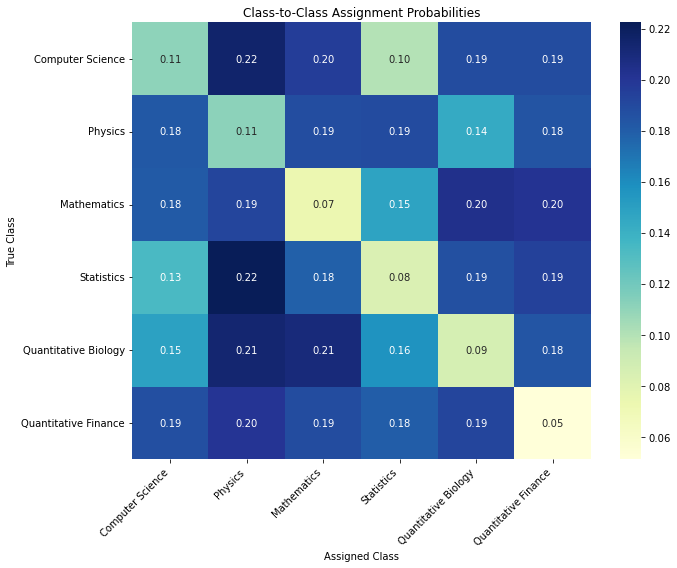

In [63]:
heatmap_prob(df)

# Oversampling

In [64]:
from imblearn.over_sampling import RandomOverSampler

In [65]:
X = train_df.loc[:,"cleaned_text"].values
y = train_df.loc[:,categories].values

In [66]:
from sklearn.utils import shuffle

class_counts = np.sum(y, axis=0)

max_count = np.max(class_counts)

X_balanced = []
y_balanced = []

for i in range(y.shape[1]):
    indices = np.where(y[:, i] == 1)[0]
    
    oversampled_indices = np.random.choice(indices, size=max_count, replace=True)
    
    X_balanced.extend(X[oversampled_indices])
    y_balanced.extend(y[oversampled_indices])

X_balanced = np.array(X_balanced)
y_balanced = np.array(y_balanced)

X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=42)

print("Shape of X_balanced:", X_balanced.shape)
print("Shape of y_balanced:", y_balanced.shape)



Shape of X_balanced: (51564,)
Shape of y_balanced: (51564, 6)


In [67]:
class_counts = np.sum(y_balanced, axis=0)
class_counts

array([15639,  9752, 11524, 15356,  8953,  8716], dtype=int64)

In [68]:
category_count_sampling = []
for i in range(len(categories)):
  category_count_sampling.append(y_balanced[y_balanced == i].shape[0]) 

Text(0.5, 1.0, 'Number of articles in each category')

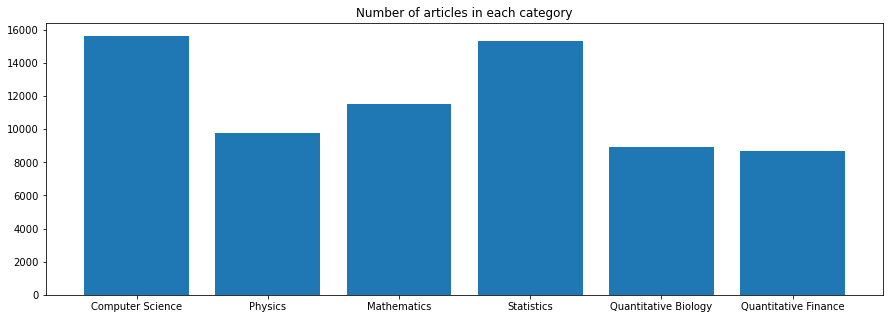

In [69]:
plt.figure(figsize=(15,5))
plt.bar(categories,class_counts)
plt.title("Number of articles in each category")

In [70]:
X_train,X_test,y_train,y_test=split(X_balanced, y_balanced,0.2)

# Tokenization and padding after oversampling the data

In [71]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [72]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)

In [73]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

# LSTM model

In [288]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 50
vocab_size

39398

In [74]:
oversampling_history = model.fit(X_train_pad, y_train, batch_size=32, epochs=10, validation_data=(X_test_pad, y_test))

Epoch 1/10
1290/1290 [==============================] - 1398s 1s/step - loss: 0.2208 - accuracy: 0.6778 - val_loss: 0.1300 - val_accuracy: 0.7914
Epoch 2/10
1290/1290 [==============================] - 1750s 1s/step - loss: 0.0962 - accuracy: 0.7693 - val_loss: 0.0940 - val_accuracy: 0.7992
Epoch 3/10
1290/1290 [==============================] - 1617s 1s/step - loss: 0.0602 - accuracy: 0.7817 - val_loss: 0.0850 - val_accuracy: 0.7108
Epoch 4/10
1290/1290 [==============================] - 1682s 1s/step - loss: 0.0424 - accuracy: 0.7923 - val_loss: 0.0714 - val_accuracy: 0.7670
Epoch 5/10
1290/1290 [==============================] - 1736s 1s/step - loss: 0.0317 - accuracy: 0.7953 - val_loss: 0.0733 - val_accuracy: 0.7344
Epoch 6/10
1290/1290 [==============================] - 1791s 1s/step - loss: 0.0231 - accuracy: 0.8038 - val_loss: 0.0678 - val_accuracy: 0.7909
Epoch 7/10
1290/1290 [==============================] - 1730s 1s/step - loss: 0.0192 - accuracy: 0.8137 - val_loss: 0.0701 -

In [75]:
y_train_pred_o = model.predict(X_train_pad)

1290/1290 [==============================] - 418s 324ms/step


In [76]:
y_test_pred_o = model.predict(X_test_pad)

323/323 [==============================] - 84s 259ms/step


In [77]:
import numpy as np
threshold = 0.7

y_train_pred_binary_o = np.where(y_train_pred_o >= threshold, 1, 0)
y_test_pred_binary_o = np.where(y_test_pred_o >= threshold, 1, 0)

In [78]:
cr = classification_report(
    y_test,
    y_test_pred_binary_o ,
    target_names=categories
)
print(cr)

                      precision    recall  f1-score   support

    Computer Science       0.96      0.94      0.95      3196
             Physics       0.97      0.96      0.96      1931
         Mathematics       0.94      0.97      0.95      2260
          Statistics       0.96      0.96      0.96      3087
Quantitative Biology       0.99      1.00      0.99      1776
Quantitative Finance       1.00      0.99      1.00      1740

           micro avg       0.97      0.97      0.97     13990
           macro avg       0.97      0.97      0.97     13990
        weighted avg       0.97      0.97      0.97     13990
         samples avg       0.97      0.97      0.96     13990



C:\Users\LEGION\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


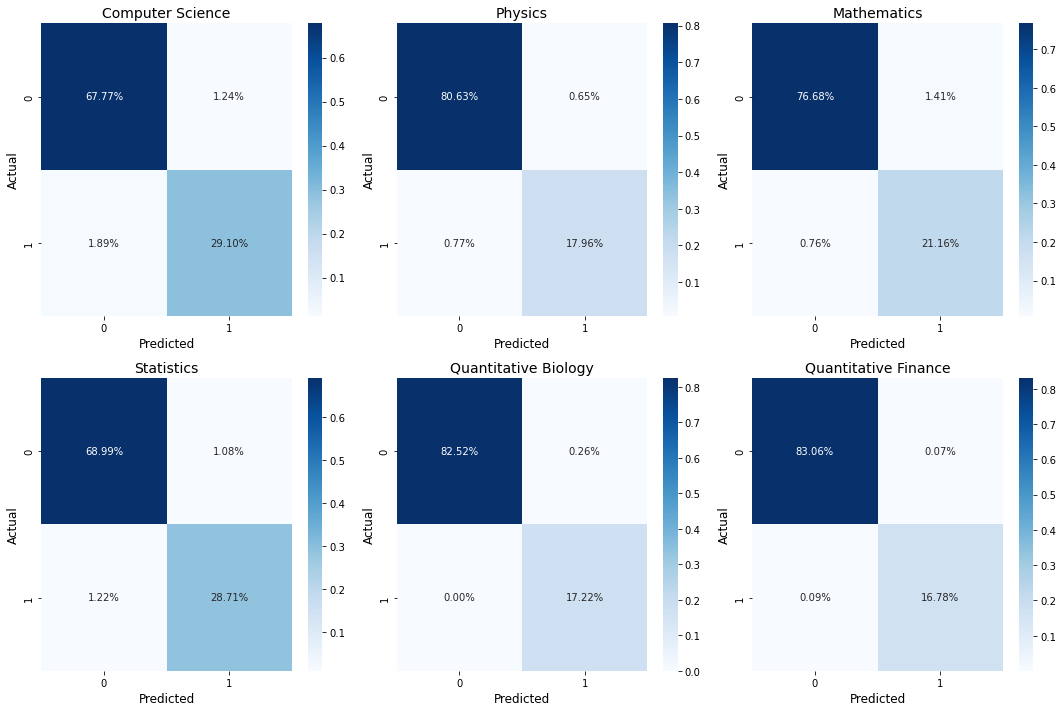

Accuracy per class:
Computer Science : 0.9686803064093862
Physics : 0.98584311063706
Mathematics : 0.9783768059730438
Statistics : 0.9770192960341316
Quantitative Biology : 0.9973819451178124
Quantitative Finance : 0.9984485600698148
All accuracy:  0.9304760981285756


In [80]:
plot_confusion_matrix(y_test, y_test_pred_binary_o , categories)

In [81]:
result_o = []

for i in range(6):
    sub_matrix = np.column_stack((y_test_pred_o[:, i],y_test_pred_o[:, i], ))
    result_o.append(sub_matrix)

print(result)

[array([[9.99140263e-01, 8.59737396e-04],
       [8.83880675e-01, 1.16119325e-01],
       [9.98651266e-01, 1.34873390e-03],
       ...,
       [1.61261682e-03, 9.98387396e-01],
       [2.37974199e-03, 9.97620285e-01],
       [9.47776973e-01, 5.22230268e-02]], dtype=float32), array([[2.6353097e-03, 9.9736470e-01],
       [1.2271230e-02, 9.8772877e-01],
       [4.2302818e-03, 9.9576974e-01],
       ...,
       [7.6436174e-01, 2.3563826e-01],
       [9.9985927e-01, 1.4072657e-04],
       [3.4239948e-02, 9.6576005e-01]], dtype=float32), array([[1.5056612e-03, 9.9849433e-01],
       [6.6809803e-01, 3.3190197e-01],
       [6.4726276e-03, 9.9352735e-01],
       ...,
       [9.7955883e-01, 2.0441175e-02],
       [7.9100940e-04, 9.9920899e-01],
       [1.1800957e-01, 8.8199043e-01]], dtype=float32), array([[2.7752431e-02, 9.7224754e-01],
       [8.0447957e-02, 9.1955203e-01],
       [2.4813583e-02, 9.7518641e-01],
       ...,
       [2.1257207e-03, 9.9787426e-01],
       [4.2808495e-04, 9.99571

In [84]:
df = matrix_prob(y_test, result_o)
df

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
Computer Science,0.543141,0.047039,0.099161,0.271903,0.023055,0.015701
Physics,0.101914,0.766419,0.088392,0.036913,0.005508,0.000855
Mathematics,0.140707,0.056945,0.615425,0.185650,0.000397,0.000875
Statistics,0.262154,0.017499,0.115276,0.508713,0.060859,0.035499
Quantitative Biology,0.048929,0.000017,0.000023,0.153014,0.783882,0.014135
Quantitative Finance,0.040405,0.000009,0.000999,0.098403,0.019961,0.840223


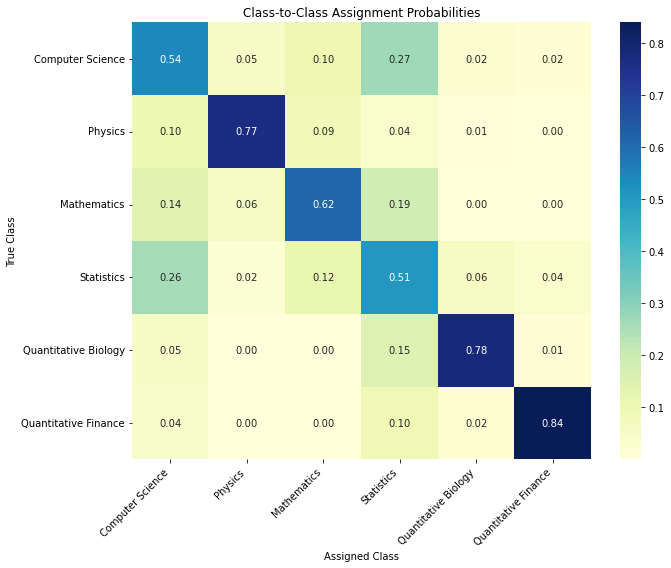

In [85]:
heatmap_prob(df)

# Creating an LSTM model with an Embedding layer

In [86]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 50
vocab_size

39756

In [87]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(LSTM(units=128))
    model.add(Dense(units=6, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Search for the best model

In [88]:
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


C:\Users\LEGION\AppData\Local\Temp\ipykernel_24492\437492748.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [89]:
y_train

array([[0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       ...,
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0]], dtype=int64)

In [90]:
X_train_pad.shape

(41251, 100)

In [91]:
tuner.search(X_train_pad, y_train, epochs=10, validation_split=0.2)
tuner.results_summary()

INFO:tensorflow:Oracle triggered exit
Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
default configuration
Score: 0.2648775577545166


In [93]:
# best_model = tuner.get_best_models(num_models=1)[0]
# best_model

###### best_model.summary()

In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
his = best_model.fit(X_train_pad, y_train, batch_size=32, epochs=10, 
                     validation_data=(X_test_pad, y_test), callbacks=[es])

# Visualization of results

In [ ]:
y_train_pred = model.predict(X_train_pad)
y_test_pred = model.predict(X_test_pad)

In [ ]:
import numpy as np
threshold = 0.7

y_train_pred_binary = np.where(y_train_pred >= threshold, 1, 0)
y_test_pred_binary = np.where(y_test_pred >= threshold, 1, 0)

In [ ]:
for row in y_train_pred_binary:
    if np.sum(row) >= 2:
        print(row)

In [ ]:
cr = classification_report(
    y_test,
    y_test_pred_binary ,
    target_names=categories
)
print(cr)

In [ ]:
plot_confusion_matrix(y_test, y_test_pred_binary , categories)

In [ ]:
result = []

for i in range(6):
    sub_matrix = np.column_stack((y_test_pred[:, i], 1 - y_test_pred[:, i]))
    result.append(sub_matrix)

print(result)

In [ ]:
df = matrix_prob(y_test, result)
df

In [ ]:
heatmap_prob(df)

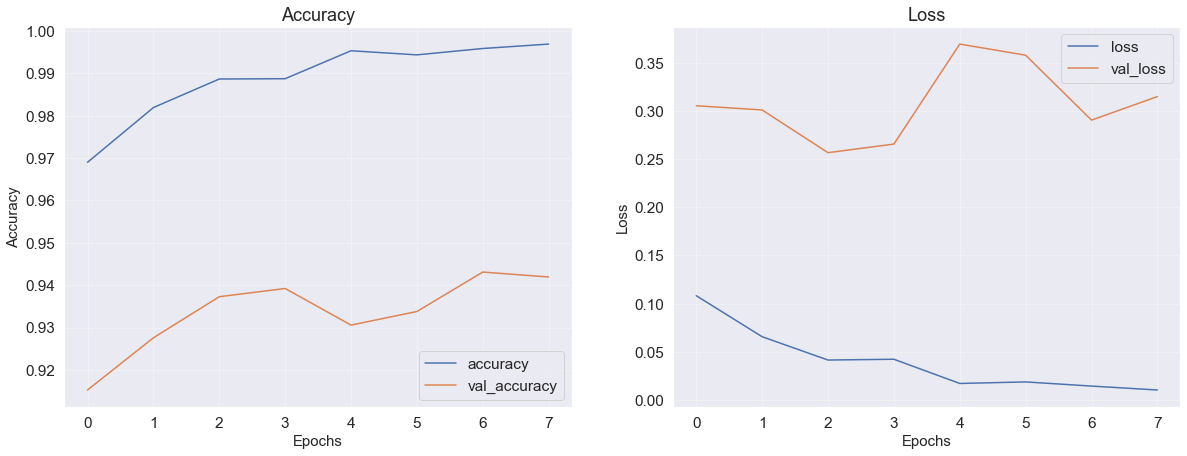

In [79]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)


plt.plot(his.epoch, his.history['accuracy'], label = "accuracy")
plt.plot(his.epoch, his.history['val_accuracy'], label = "val_accuracy")

plt.title("Accuracy", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

fig.add_subplot(122)

plt.plot(his.epoch, his.history['loss'], label="loss")
plt.plot(his.epoch, his.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()